In [38]:
import os
import csv
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt
# np.set_printoptions(threshold=sys.maxsize)

In [39]:
def dnorm(x, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power(x / sd, 2) / 2)

In [40]:
def myGaussianKernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], sigma)
    print(kernel_1D)

    kernel_2D = np.outer(kernel_1D, kernel_1D)
    kernel_2D *= 1.0 / kernel_2D.max()

    plt.imshow(kernel_2D, interpolation='none', cmap='gray')
    plt.title("Gaussian Kernel Image")

    if verbose:
        plt.show()
    else:
        plt.savefig(os.path.join("output", f"gk{size}_{sigma}.png"))

    return kernel_2D

In [41]:
def myBoxKernel(size, sigma=1, verbose=False):
    kernel_2D = np.ones((size, size)) / 9

    plt.imshow(kernel_2D, interpolation='none', cmap='gray')
    plt.title("Box Kernel Image")

    if verbose:
        plt.show()
    else:
        plt.savefig(os.path.join("output", f"gk{size}_{sigma}.png"))

    return kernel_2D

[0.24197072 0.39894228 0.24197072]


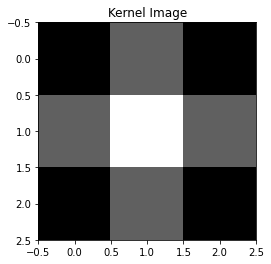

array([[0.36787944, 0.60653066, 0.36787944],
       [0.60653066, 1.        , 0.60653066],
       [0.36787944, 0.60653066, 0.36787944]])

In [42]:
# kernel = cv2.getGaussianKernel(5, sigma=2) # skip built in method
kernel = myGaussianKernel(size=3, sigma=1, verbose=True)
# kernel = myBoxKernel(size=3, verbose=True)
kernel

In [43]:
def myImageFilter(image, kernel, average=False, verbose=False):
    print("Image Shape : {}".format(image.shape))
    print("Kernel Shape : {}".format(kernel.shape))

    if verbose:
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.show()

    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape

    output = np.zeros(image.shape)

    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)

    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))

    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image

    if verbose:
        plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.show()

    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]

    print("Output Image Size : {}".format(output.shape))

    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()

    return output

In [44]:
def saveCornerResult(filename, output_dir, corner_list, corner_img):
    with open(os.path.join(output_dir, f"{filename}_corners.csv"), 'w') as corner_file:
        writer = csv.DictWriter(corner_file, fieldnames=["x", "y", "r"])
        writer.writeheader()
        for i in range(len(corner_list)):
            writer.writerow({
                "x": str(corner_list[i][0]),
                "y": str(corner_list[i][1]),
                "r": str(corner_list[i][2])
            })

    if corner_img is not None:
        cv2.imwrite(os.path.join(output_dir, f"{filename}.png"), corner_img)

In [50]:
def findImageCorners(filepath, kernel, verbose=False):
    input_img = cv2.imread(filepath)
    gray_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    output_dir = None
    
    if verbose:
        plt.title("Input Image")
        plt.imshow(gray_img, cmap='gray')
        plt.show()
    else:
        filename = filepath.split(os.path.sep, 2)[-1]
        dynamic_dir = filename.replace('.', '_')
        output_dir = os.path.join("output", dynamic_dir)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
    
    window_size = 5

    # Gx, Gy = np.gradient(gray_img) # skip builtin method
    Gxy = myImageFilter(gray_img, kernel, average=True)
    Gy = np.diff(Gxy, axis=0, append=0)
    plt.title("y derivative image")
    plt.imshow(Gy, cmap='gray')
    if verbose:
        plt.show()
    else:
        plt.savefig(os.path.join(output_dir, f"gy.png"))
     
    Gx = np.diff(Gxy, axis=1, append=0)
    plt.title("x derivative image")
    plt.imshow(Gx, cmap='gray')
    if verbose:
        plt.show()
    else:
        plt.savefig(os.path.join(output_dir, f"gx.png"))
    
    offset = int(window_size / 2)
    y_range = gray_img.shape[0] - offset
    x_range = gray_img.shape[1] - offset

    # print("Gxy Shape : {}".format(Gxy.shape))
    print("Gx Shape : {}".format(Gx.shape))
    print("Gy Shape : {}".format(Gy.shape))

    Ixx = Gx ** 2
    Ixy = Gy * Gx
    Iyy = Gy ** 2

    harris_corner_list = []
    harris_output_img = cv2.cvtColor(gray_img.copy(), cv2.COLOR_GRAY2RGB)
    
    kanade_corner_list = []
    kanade_output_img = cv2.cvtColor(gray_img.copy(), cv2.COLOR_GRAY2RGB)
    
    nobel_corner_list = []
    nobel_output_img = cv2.cvtColor(gray_img.copy(), cv2.COLOR_GRAY2RGB)
    
    for y in range(offset, y_range):
        for x in range(offset, x_range):
            # Values of sliding window
            start_y = y - offset
            end_y = y + offset + 1
            start_x = x - offset
            end_x = x + offset + 1

            # The variable names are representative to
            # the variable of the Harris corner equation
            windowIxx = Ixx[start_y: end_y, start_x: end_x]
            windowIxy = Ixy[start_y: end_y, start_x: end_x]
            windowIyy = Iyy[start_y: end_y, start_x: end_x]

            # Sum of squares of intensities of partial derevatives
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()
            
            M = np.array([[Sxx, Sxy],[Sxy, Syy]])

            # Calculate determinant and trace of the matrix
            det = (Sxx * Syy) - (Sxy ** 2)
            trace = Sxx + Syy
            
            # Calculate r for Harris Corner equation
            title = "Harris"
            k = 0.04
            r = det - k * (trace ** 2)
            threshold = 10000.00
            if r > threshold:
                harris_corner_list.append([x, y, r])
                # cv2.circle(output_img, (x, y), 1, 255, -1)
                harris_output_img[y, x] = (0, 0, 255)
            
            # Calculate r for Kanade & Tomasi Corner equation
            title = "Kanade & Tomasi"
            # lamda1 * lamda2 = det
            # lamda1 + lamda2 = trace
            w, v = np.linalg.eig(M)
            r = np.min(w)
            threshold = 1.00
            if r > threshold:
                kanade_corner_list.append([x, y, r])
                # cv2.circle(output_img, (x, y), 1, 255, -1)
                kanade_output_img[y, x] = (0, 0, 255)
            
            # Calculate r for Nobel Corner equation
            title = "Nobel"
            e = 1
            r = det / (trace + e)
            threshold = 100.00
            if r > threshold:
                nobel_corner_list.append([x, y, r])
                # cv2.circle(output_img, (x, y), 1, 255, -1)
                nobel_output_img[y, x] = (0, 0, 255)
            
    if verbose:
        plt.title("Harris Output Image")
        plt.imshow(harris_output_img, cmap='gray')
        plt.show()
        
        plt.title("Kanade & Tomasi Output Image")
        plt.imshow(kanade_output_img, cmap='gray')
        plt.show()
        
        plt.title(f"Nobel Output Image")
        plt.imshow(nobel_output_img, cmap='gray')
        plt.show()
    else:
        saveCornerResult("harris", output_dir, harris_corner_list, harris_output_img)
        saveCornerResult("kanade", output_dir, kanade_corner_list, kanade_output_img)
        saveCornerResult("nobel", output_dir, nobel_corner_list, nobel_output_img)

Image Shape : (256, 256)
Kernel Shape : (3, 3)
Output Image Size : (256, 256)
Gx Shape : (256, 256)
Gy Shape : (256, 256)


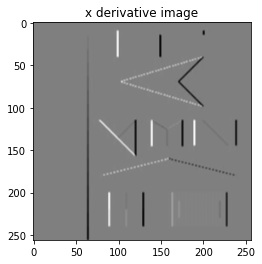

In [51]:
filepath = os.path.join("images", "img1.png")
findImageCorners(filepath, kernel, verbose=False)

In [ ]:
def main():
    files = glob.glob(os.path.join("images", "img*"))
    for fpath in files:
        if os.path.isfile(fpath):
            findImageCorners(fpath, kernel, verbose=False)